In [23]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons
from copy import deepcopy

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot

from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping

solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [24]:

##Dates
#From general trajectory, we can arrive conservatively between june 17th 2037 & 6th august
arrival_date_first=time.Time("2037-06-17 00:01", scale="utc").tdb
arrival_date_second=time.Time("2037-06-21 00:01", scale="utc").tdb  
arrival_dates=time_range(arrival_date_first, end=arrival_date_second, periods=200)
sim_end_date = time.Time("2038-05-01 00:01", scale="utc").tdb

simulation_epoch=time_range(start=arrival_date_first,end=sim_end_date)
io_ephem = Ephem.from_horizons(501,epochs= simulation_epoch, attractor= Jupiter)#Io is 501
ganymede_ephem = Ephem.from_horizons(503,epochs= simulation_epoch, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Ganymede is 503
europa_ephem = Ephem.from_horizons(502,epochs= simulation_epoch, attractor= Jupiter)#Europa is 502
callisto_ephem = Ephem.from_horizons(504,epochs= simulation_epoch, attractor= Jupiter)

##Orbital Insertion Parameters
c3 = 550*u.km**2/u.s**2  
r_perijove = Jupiter.R+1000 * u.km
r_apijove = Jupiter.R+2e7*u.km

placeholder_ganymede_orbit=Orbit.from_ephem(Jupiter,ganymede_ephem,arrival_date_first)


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



In [25]:
# arrival_date=arrival_date_first
# plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)

lowest_dv=1000*u.m/u.s
character=[]

for arrival_date in arrival_dates:   
    a_exit = (r_perijove+r_apijove)/2
    ecc_exit = (r_perijove-r_apijove)/(r_perijove+r_apijove)


    arrival_orbit = Orbit.from_classical(
        Jupiter,
        a_exit,
        ecc_exit,
        placeholder_ganymede_orbit.inc,
        placeholder_ganymede_orbit.raan,
        0 * u.deg,
        180 * u.deg,  
        time.Time(arrival_date, scale="utc"),
        plane=Planes.EARTH_ECLIPTIC
    )
    for tof in range(55,65)*u.day:
        ganymede_orb= Orbit.from_ephem(Jupiter,ganymede_ephem,arrival_date+tof)
        lambert=Maneuver.lambert(arrival_orbit,ganymede_orb,M=0)
        dv=np.linalg.norm(lambert[0][1])
        if dv<lowest_dv:
            lowest_dv=dv
            character=[arrival_date,tof,arrival_orbit,lambert]
print(lowest_dv)
print(character)
arrival_date_final=character[0]
tof_final=character[1]



/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/astropy/units/decorators.py:302: UserWarning:

Wrapping true anomaly to -π <= nu < π



134.26014061762876 m / s
[<Time object: scale='tdb' format='iso' value=2037-06-17 07:45:16.119>, <Quantity 61. d>, 0 x 0 AU x 2.3 deg orbit around Jupiter (♃) at epoch 2037-06-17 07:44:06.935 (UTC), Number of impulses: 2, Total cost: 15.663588 km / s]


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"



51.748645838789415 d
61.61021577558131 d


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"



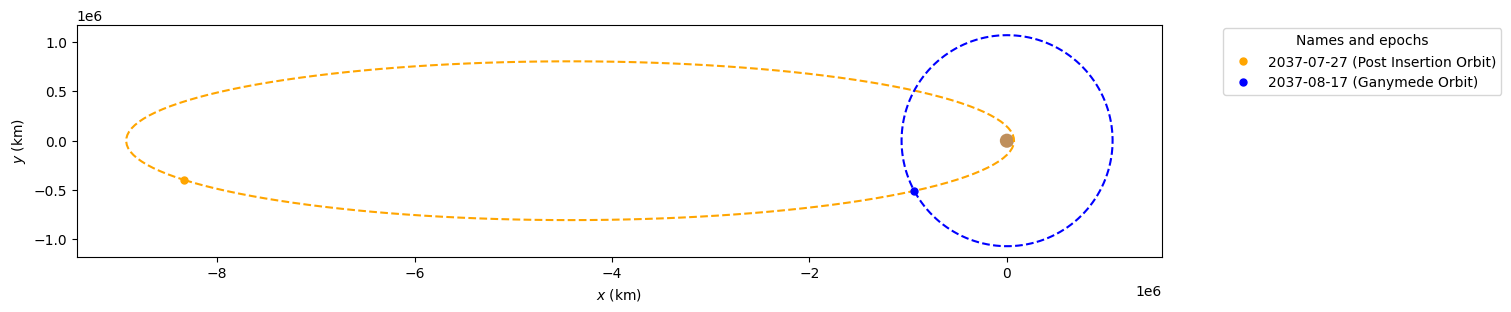

In [28]:

#initial orbit plots

plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
post_insertion_orb,dummy=character[2].apply_maneuver(character[3],intermediate=True)
post_insertion_orb=post_insertion_orb.propagate(2*tof_final/3)
print(post_insertion_orb.t_a_fut.to(u.day))
print(post_insertion_orb.period.to(u.day))
plotter.plot(post_insertion_orb, label="Post Insertion Orbit", color="orange")

ganymede_orb= Orbit.from_ephem(Jupiter,ganymede_ephem,character[0]+character[1])
plotter.plot(ganymede_orb, label="Ganymede Orbit", color="blue")        




21.24864583878942 d
61.61021577558131 d


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



Ok, so from general trajectory, we have an arrival at Ganymede on 17th August 2037 from an insertion on 17th June with ~(0.5+0.13)km/s DV. 




-find direction that slows you down relative to Jupiter
-look for orbits that are rational multiple of orbit of the moon

In [46]:

def find_assist_periapsis_bounds(dep_num,sling_bod_orb,inc_orb_vel,date):
    sling_body=planet_order[dep_num]
    target_body = planet_order[dep_num+1]

    #relative velocity & speed to body we are slingshotting around
    rel_vel = inc_orb_vel-sling_bod_orb.rv()[1]
    rel_sped = np.linalg.norm(rel_vel)
    
    r_ps = sling_body.R+np.geomspace(r_p_min,r_p_max,num=int(assist_transit_resolution/2))
    rot_angs=2*np.arcsin(1/((r_ps*rel_sped*rel_sped/sling_body.k)+1*u.one))
    #Now check if these (in plane) rotations lead to an orbit that reaches the target body
    target_body_debug_orbit = Orbit.from_ephem(Jupiter,ephem_order[dep_num+1],date)
    
    axis = np.array([0,0,1.0])   #rotate in ecliptic plane intitially
    min_dv=1000000*u.km/u.s
    target_arrival_date=None
    flyby_rp=None
    print(r_ps[17])

    for sign in [-1]:
        for i in range(len(rot_angs)):
        # i=0
            rot = scipyRot.from_rotvec(sign*axis*rot_angs[i])
            rel_vel_out= rot.apply(1*rel_vel.value) * u.km/u.s
            test_orb = Orbit.from_vectors(Jupiter,sling_bod_orb.r,rel_vel_out+sling_bod_orb.rv()[1],date,plane=Planes.EARTH_ECLIPTIC)
            #check if apogee of new orbit reaches target, or is hyperbolic
            #Note, does not work for gravity assists to bodies in lower orbits,
            #Thus will need changes for Jovian grand tour
            if (test_orb.r_p.value<target_body_debug_orbit.r_p.value and test_orb.ecc <1):
                #find time to reach target
                time_to_next=test_orb.t_a_fut
                reached_next_bod=False
                test_orb_prop=test_orb.propagate(time_to_next)
                # print(test_orb_prop.nu)
                while not reached_next_bod:
                    # print(time_to_next.to(u.day))
                    test_orb_prop=test_orb_prop.propagate(0.1*u.day)
                    time_to_next += 0.1*u.day
                    if np.linalg.norm(test_orb_prop.rv()[0]) < target_body_debug_orbit.a:
                        reached_next_bod=True
                rough_arrival_date = date+time_to_next
                print(f"Arrival at {target_body} at roughly {rough_arrival_date}")
                target_arrival_orb = Orbit.from_ephem(Jupiter,ephem_order[dep_num+1],rough_arrival_date)   
                #Now evaluate lambert to target body
                man_lambert = Maneuver.lambert(sling_bod_orb, target_arrival_orb)
                lambert_test_orb=sling_bod_orb.apply_maneuver(man_lambert,intermediate=True)[0]
                # print(lambert_test_orb.r)
                # print(sling_bod_orb.r)
                # print(test_orb.r)
                speed_dif=abs(np.linalg.norm((lambert_test_orb.rv()[1]-sling_bod_orb.rv()[1])) - np.linalg.norm((test_orb.rv()[1]-sling_bod_orb.rv()[1])))
                if speed_dif < min_dv:
                    # print(min_dv.to(u.km/u.s))
                    min_dv=speed_dif
                    target_arrival_date=deepcopy(rough_arrival_date)
                    flyby_rp=sign*r_ps[i]

            # print(f"It takes {min_dv} to reach {target_body.name} arriving at {target_arrival_date}")
            # print(f"Trying to arrive at {target_body.name} on {target_arrival_date} leaving on {date}")
    target_arrival_orb = Orbit.from_ephem(Jupiter, ephem_order[dep_num + 1], target_arrival_date)
    man_lambert = Maneuver.lambert(sling_bod_orb, target_arrival_orb)
    outgoing_orb = sling_bod_orb.apply_maneuver(man_lambert, intermediate=True)[0]       

    # plotter.plot(test_orb, label="Test Orbit Propagation")
    # plotter.plot(target_arrival_orb, label=f"{target_body.name} Orbit")
    # plotter.plot(outgoing_orb, label=f"Post-Assist Orbit")
    # plotter.plot(sling_bod_orb, label=f"{sling_body.name} Orbit")
    return min_dv, target_arrival_date, outgoing_orb#, flyby_rp

In [9]:
planet_order=[Ganymede,Ganymede,Ganymede]
ephem_order=[ganymede_ephem,ganymede_ephem,ganymede_ephem]


r_p_min=10*u.km
r_p_max=8000*u.km
assist_transit_resolution=150

initial_orbit=deepcopy(post_insertion_orb)
initial_orbit=initial_orbit.propagate(tof_final)
initial_assist_date=arrival_date_final+tof_final
print(initial_orbit)

72492 x 8921680 km x 2.3 deg orbit around Jupiter (♃) at epoch 2037-08-17 07:44:06.935 (UTC)


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"



In [28]:

#initial_orbit
dv_maneuvers_total=0
starship_orbits=[]
moon_orbits=[]



dv_maneuvers_total,arrive_bod_2_date, orb_after_1=find_assist_periapsis_bounds(0,ganymede_orb,initial_orbit.rv()[1],initial_assist_date)
if(dv_maneuvers_total<100*u.m/u.s):
    print(f"Viable assist at {initial_assist_date} with {planet_order[0]} to {planet_order[1]} arrving at {arrive_bod_2_date}.")
    bod_2_arriv_orb=orb_after_1.propagate(arrive_bod_2_date)
    bod_2_orb=Orbit.from_ephem(Jupiter, ephem_order[1], arrive_bod_2_date)
    moon_orbits.append(bod_2_orb)
    starship_orbits.append(bod_2_arriv_orb)
    next_dv,arrive_bod_3_date,orb_after_2=find_assist_periapsis_bounds(1,bod_2_orb,bod_2_arriv_orb.rv()[1],arrive_bod_2_date)
    if(next_dv<100*u.m/u.s):
        print(f"Viable 2nd assist arriving at {planet_order[2]} on {arrive_bod_3_date} with {next_dv.to(u.m/u.s)} at {planet_order[2]} at {arrive_bod_2_date}")
        dv_maneuvers_total+=next_dv
        moon_orbits.append(Orbit.from_ephem(Jupiter, ephem_order[2], arrive_bod_3_date))
        starship_orbits.append(orb_after_2.propagate(arrive_bod_3_date))
    else:
        print("No viable 2nd assist found.")

print(f"Total DV for assists: {dv_maneuvers_total.to(u.m/u.s)}")




-4810139.577453047 s


AssertionError: 

Period of starship orbit after assist 1: 42.53934251746993 d
Period of starship orbit after assist 2: 43.32640707708409 d


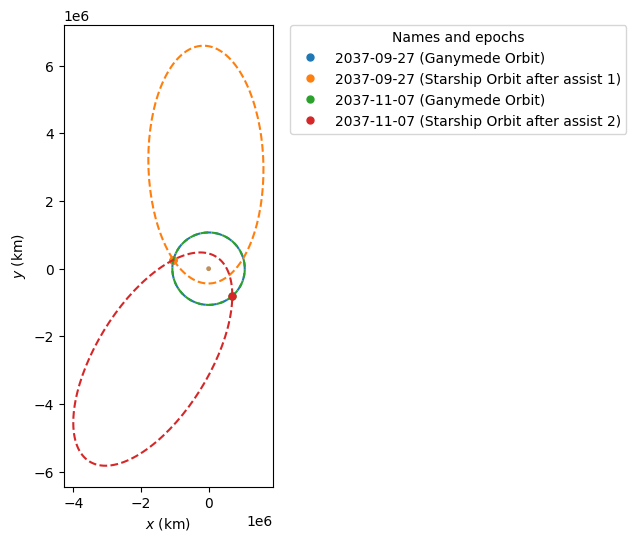

In [ ]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
for i in range(len(moon_orbits)):
    plotter.plot(moon_orbits[i], label=f"{planet_order[i+1].name} Orbit")
    plotter.plot(starship_orbits[i], label=f"Starship Orbit after assist {i+1}")
    print(f"Period of starship orbit after assist {i+1}: {starship_orbits[i].period.to(u.day)}")

In [47]:
test_dv,test_date,test_orb,test_rp=find_assist_periapsis_bounds(0,ganymede_orb,initial_orbit.rv()[1],arrival_date_final+tof_final)      

plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
ganymede_orb_debug= Orbit.from_ephem(Jupiter,ganymede_ephem,test_date)
plotter.plot(initial_orbit, label="Initial Orbit")
plotter.plot(test_orb, label="Test Orbit Propagation")
plotter.plot(ganymede_orb_debug, label=f"Ganymede Orbit")

# print(test_date)
print(test_dv.to(u.km/u.s))
print(test_rp.to(u.km))

2680543.621611806 m
Arrival at Ganymede (●) at roughly 2037-12-07 22:08:09.219
Arrival at Ganymede (●) at roughly 2037-12-07 21:46:50.347


AssertionError: 